# HW 1-2: Optimization
## CPSC 8430
## Adam Patyk

In [1]:
import numpy as np
import torch

### Part 1: Visualize the Optimization Process

In [29]:
from torch.utils.data import DataLoader
from common.FunctionDataset import FunctionDataset

## -------------------------
## Prepare data for training
## -------------------------

num_data_points = 100
range_min = 0
range_max = 1

# create data points from function e^x * sin^2(3*pi*x) over a range
raw_data = FunctionDataset(num_data_points, range_min, range_max)

# z-score standardize training data
training_data = raw_data.standardize()

# create data loader for training
training_loader = DataLoader(training_data, batch_size=1, shuffle=True)

print('Data ready.')

Data ready.


In [92]:
from common.DNN_Models import ModerateNetwork

## --------------------------------------------------
## Train model multiple times logging loss and weights
## ---------------------------------------------------

# helper function to get flattened weights of a sequential model
def get_fc_weights(model):
  all_weights = np.zeros((1,0))
  layer_weights = np.zeros((1,0))
  for name, param in model.named_parameters():
    if 'weight' in name:
      # flatten all weights to 1D arrays 
      all_weights = np.concatenate((all_weights, param.data.view(1, -1).numpy()), axis=None)
      if 'fc2' in name:
        # save flattened weights from FC2 layer
        #layer_weights = param.data.view(-1).numpy()
        layer_weights = np.concatenate((layer_weights, param.data.view(1, -1).numpy()), axis=None)
  return layer_weights, all_weights

epochs = 90
num_training_times = 8
num_layers = 4

overall_loss = []
overall_weights = []
single_layer_weights = []

for i in range(num_training_times):
  # reset model between training
  DNN_Model = ModerateNetwork()
  DNN_Model.zero_grad()

  print(f'Training model - {i+1}')
  for epoch in range(epochs):
    loss = DNN_Model.train(training_loader)
    single_layer_w, all_w = get_fc_weights(DNN_Model)
    # log loss and weights every 3 epochs
    if epoch % 3 == 0: 
      overall_loss.append(loss)
      overall_weights.append(all_w)
      single_layer_weights.append(single_layer_w)

  print(f'Done. Loss: {loss:.6f}', flush=True)


Training model - 1
Done. Loss: 1.078062
Training model - 2
Done. Loss: 0.694698
Training model - 3
Done. Loss: 0.131222
Training model - 4
Done. Loss: 0.818672
Training model - 5
Done. Loss: 0.512265
Training model - 6
Done. Loss: 1.114933
Training model - 7
Done. Loss: 0.373202
Training model - 8
Done. Loss: 0.728917


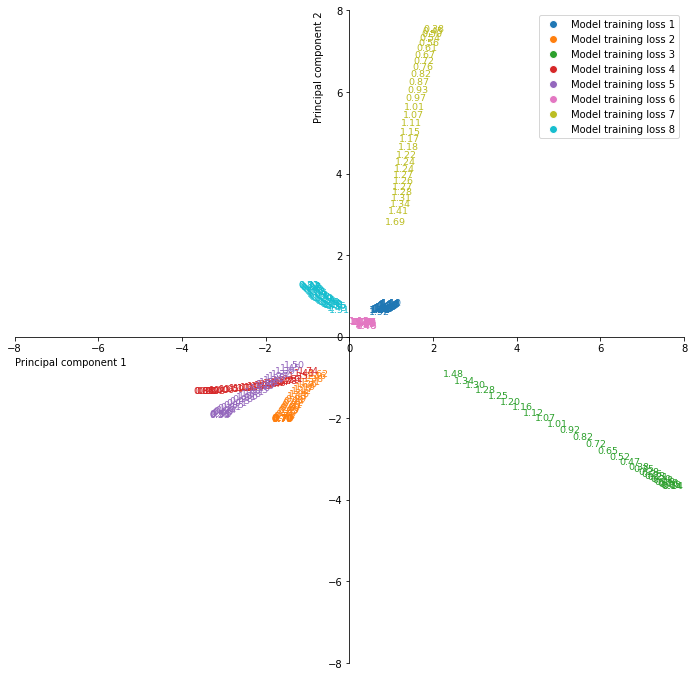

In [101]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## ------------------------------------------
## Plot PCA results to visualize optimization
## ------------------------------------------

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan']
legend_elements =[]
for i in range(len(colors)):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
            label=f'Model training loss {i+1}', markerfacecolor=colors[i], markersize=8))

segment_length = epochs // 3
training_segments = segment_length * num_training_times
pca = PCA(n_components=2)

# entire model
principalComponents = pca.fit_transform(overall_weights)

fig = plt.figure(figsize=(12,12))
plt.axis([-8, 8, -8, 8])

for segment in range(num_training_times):
    start_idx = segment * segment_length
    end_idx = (segment+1) * segment_length
    for i in range(start_idx, end_idx):
        plt.text(principalComponents[i, 0],
                principalComponents[i, 1],
                '%.2f' % overall_loss[i],
                fontdict={'size': 9.5},
                color=colors[segment])
ax = plt.gca()
ax.legend(handles=legend_elements)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Principal component 1', loc='left')
plt.ylabel('Principal component 2', loc='top')
plt.savefig('results/2/entire_model_pca.pdf')
plt.show()

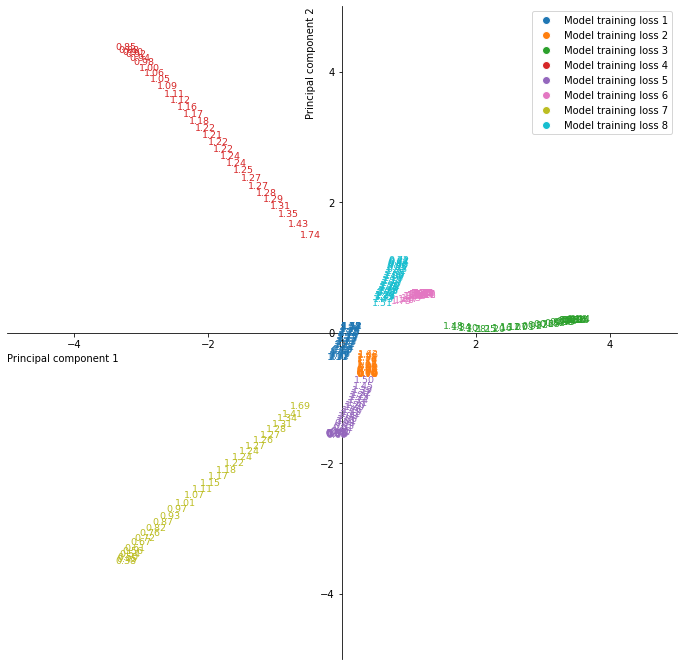

In [102]:
# single layer (FC2)
principalComponents = pca.fit_transform(single_layer_weights)

fig = plt.figure(figsize=(12,12))
plt.axis([-5, 5, -5, 5])

for segment in range(num_training_times):
    start_idx = segment * segment_length
    end_idx = (segment+1) * segment_length
    for i in range(start_idx, end_idx):
        plt.text(principalComponents[i, 0],
                principalComponents[i, 1],
                '%.2f' % overall_loss[i],
                fontdict={'size': 9.5},
                color=colors[segment])
ax = plt.gca()
ax.legend(handles=legend_elements)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Principal component 1', loc='left')
plt.ylabel('Principal component 2', loc='top')
plt.savefig('results/2/single_layer_pca.pdf')
plt.show()

### Part 2: Observe Gradient Norm During Training

In [22]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from common.FunctionDataset import FunctionDataset

## ------------------------
## Create data for training
## ------------------------

num_data_points = 100
range_min = 0
range_max = 1
img_batch_size = 32

# prepare data for e^x * sin^2(3*pi*x) function 
raw_func_data = FunctionDataset(num_data_points, range_min, range_max)
func_training_data = raw_func_data.standardize()
func_training_loader = DataLoader(func_training_data, batch_size=1, shuffle=True)

# prepare data for MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
mnist_training_set = torchvision.datasets.MNIST(root='./data/', train=True, 
                                          download=True, transform=transform)
mnist_training_loader = torch.utils.data.DataLoader(mnist_training_set, 
                                          batch_size=img_batch_size,
                                          shuffle=True)

print('Data ready.')

Data ready.


In [23]:
from common.DNN_Models import ModerateNetwork
from common.MNIST_CNN_Models import ModerateCNN

## ---------------------------------
## Train models [est. time: 30 min] 
## ---------------------------------

# helper function to calculate the gradient normal (p-norm, p=2)
def calc_grad_norm(model):
  grad_all = 0.0

  for p in model.parameters():
    grad = 0.0 
    if p.grad is not None:
      grad = (p.grad.cpu().data.numpy() ** 2).sum()
    grad_all += grad

  grad_norm = grad_all ** 0.5

  return grad_norm

DNN_epochs = 10000
CNN_epochs = 100

DNN_model = ModerateNetwork()
CNN_model = ModerateCNN()

DNN_model.zero_grad()
CNN_model.zero_grad()

overall_grad_norm = []
overall_loss = []
model_loss = []
model_grad_norm = []

# train both models logging gradient norm and loss 
print('Training DNN model:')
for epoch in range(DNN_epochs):
    loss = DNN_model.train(func_training_loader)
    grad_norm = calc_grad_norm(DNN_model)
    model_loss.append(loss)
    model_grad_norm.append(grad_norm)
    if epoch % (DNN_epochs/10) == (DNN_epochs/10)-1: # print updates 10 times
      print(f'Epoch: {epoch+1}/{DNN_epochs}\tLoss: {loss:.6f}\tGrad norm: {grad_norm:.2f}', flush=True)

overall_loss.append(model_loss)
overall_grad_norm.append(model_grad_norm)

model_loss = []
model_grad_norm = []
print('Training CNN model:')
for epoch in range(CNN_epochs):
    loss = CNN_model.train(mnist_training_loader)
    grad_norm = calc_grad_norm(CNN_model)
    model_loss.append(loss)
    model_grad_norm.append(grad_norm)
    if epoch % (CNN_epochs/10) == (CNN_epochs/10)-1: # print updates 10 times
      print(f'Epoch: {epoch+1}/{CNN_epochs}\t\tLoss: {loss:.6f}\tGrad norm: {grad_norm:.2f}', flush=True)

overall_loss.append(model_loss)
overall_grad_norm.append(model_grad_norm)

Training DNN model:
Epoch: 1000/10000	Loss: 0.008870	Grad norm: 4.50
Epoch: 2000/10000	Loss: 0.009815	Grad norm: 1.72
Epoch: 3000/10000	Loss: 0.005455	Grad norm: 1.97
Epoch: 4000/10000	Loss: 0.002806	Grad norm: 0.04
Epoch: 5000/10000	Loss: 0.002581	Grad norm: 0.39
Epoch: 6000/10000	Loss: 0.002374	Grad norm: 0.01
Epoch: 7000/10000	Loss: 0.003419	Grad norm: 1.29
Epoch: 8000/10000	Loss: 0.002271	Grad norm: 0.25
Epoch: 9000/10000	Loss: 0.002314	Grad norm: 0.37
Epoch: 10000/10000	Loss: 0.001790	Grad norm: 0.51
Training CNN model:
Epoch: 10/100		Loss: 0.015136	Grad norm: 0.26
Epoch: 20/100		Loss: 0.005247	Grad norm: 0.02
Epoch: 30/100		Loss: 0.000086	Grad norm: 0.01
Epoch: 40/100		Loss: 0.000028	Grad norm: 0.00
Epoch: 50/100		Loss: 0.000018	Grad norm: 0.00
Epoch: 60/100		Loss: 0.000013	Grad norm: 0.00
Epoch: 70/100		Loss: 0.000011	Grad norm: 0.01
Epoch: 80/100		Loss: 0.000009	Grad norm: 0.00
Epoch: 90/100		Loss: 0.000008	Grad norm: 0.00
Epoch: 100/100		Loss: 0.000007	Grad norm: 0.00


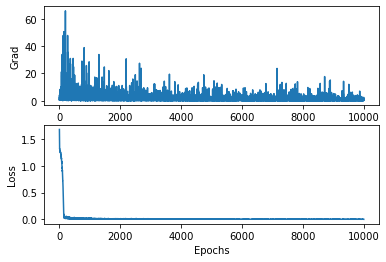

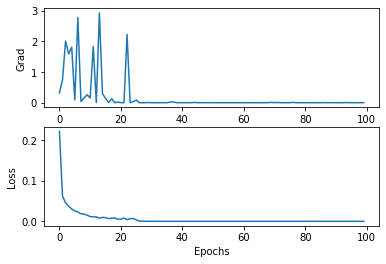

In [25]:
import matplotlib.pyplot as plt

## ---------------------------
## Plot loss and gradient norm
## ---------------------------

epochs = [DNN_epochs, CNN_epochs]
names = ['dnn', 'cnn']

for i in range(2):
  fig, axs = plt.subplots(2)
  axs[0].plot(np.arange(0, epochs[i]), overall_grad_norm[i])
  axs[1].plot(np.arange(0, epochs[i]), overall_loss[i])
  plt.xlabel('Epochs')
  axs[0].set(ylabel='Grad')
  axs[1].set(ylabel='Loss')
  plt.savefig(f'results/2/gradient_norm_{names[i]}.pdf')
  plt.show()

### Part 3: What Happens When Gradient Is Almost Zero?

In [ ]:
from common.FunctionDataset import FunctionDataset

## -------------------------
## Prepare data for training
## -------------------------

num_data_points = 100
range_min = 0
range_max = 1

# create data points from function e^x * sin^2(3*pi*x) over a range
raw_data = FunctionDataset(num_data_points, range_min, range_max)

# z-score standardize training data
training_data = raw_data.standardize()

# create data loader for training
training_loader = DataLoader(training_data, batch_size=1, shuffle=True)

print('Data ready.')

In [ ]:
from common.DNN_Models import ModerateNetwork

## -----------
## Train model
## -----------

epochs = 100
DNN_Model = ModerateNetwork()

# helper function to calculate the gradient normal (p-norm, p=2)
def calc_grad_norm(model):
  grad_all = 0.0

  for p in model.parameters():
    grad = 0.0 
    if p.grad is not None:
      grad = torch.sum(p.grad.cpu().data ** 2)
    grad_all += grad

  grad_norm = grad_all ** 0.5

  return grad_norm

model_loss = []
DNN_Model.zero_grad()

print('Training model')
# train once with default loss function (MSE)
loss = DNN_Model.train(training_loader)
print(f'Epoch: 1/{epochs}\t\tLoss: {loss:.6f}', flush=True)
model_loss.append(loss)

# swap to minimizing grad norm
for epoch in range(1, epochs):
  grad_norm = train_zero_grad(DNN_Model)
  if epoch % (epochs/10) == (epochs/10)-1: 
    print(f'Epoch: {epoch+1}/{epochs}\t\Grad Norm: {grad_norm:.6f}', flush=True)
  model_loss.append(loss)